# Sistema de agrupación de casas (California Housing)


## 1. Imports y configuración

In [1]:
# Se importan librerías base de análisis y visualización.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Se importan utilidades de ML para dividir datos, escalar y entrenar modelos.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Se importan métricas y un modelo supervisado para aprender los clusters.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Se importa joblib para guardar modelos (más cómodo que pickle para sklearn).
import joblib

# (Opcional) Para que los resultados de numpy/pandas sean más legibles.
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## 2. Carga del dataset
Solo se usarán: **Latitude**, **Longitude**, **MedInc**.

**Tip:** si el enlace falla, se puede descargar el CSV y cambiar `DATA_PATH` a la ruta local.

In [2]:
# Se define la ruta del dataset (URL o ruta local).
DATA_PATH = "https://breathecode.herokuapp.com/asset/internal-link?id=809&path=housing.csv"

# Se carga el dataset.
df = pd.read_csv(DATA_PATH)

# Se revisa la estructura.
print("Shape:", df.shape)
display(df.head())

# Se revisa información general (tipos y nulos).
display(df.info())

# Se seleccionan únicamente las columnas solicitadas.
cols = ["Latitude", "Longitude", "MedInc"]
df = df[cols].copy()

# Se revisa el dataset ya filtrado.
print("\nColumnas usadas:", df.columns.tolist())
display(df.describe())


Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None


Columnas usadas: ['Latitude', 'Longitude', 'MedInc']


,Latitude,Longitude,MedInc
count,20640.000000,20640.000000,20640.000000
mean,35.631861,-119.569704,3.870671
std,2.135952,2.003532,1.899822
min,32.540000,-124.350000,0.499900
25%,33.930000,-121.800000,2.563400
50%,34.260000,-118.490000,3.534800
75%,37.710000,-118.010000,4.743250
max,41.950000,-114.310000,15.000100


## 3. Limpieza rápida
K-Means no acepta nulos. Si hay nulos, se imputan o se eliminan filas.
Aquí se elimina cualquier fila con nulos en las 3 columnas (suficiente para el ejercicio).

In [3]:
# Se cuentan nulos por columna.
print("Nulos por columna:\n", df.isnull().sum())

# Se eliminan filas con nulos en las columnas usadas.
df = df.dropna().reset_index(drop=True)

print("\nShape después de dropna:", df.shape)


Nulos por columna:
 Latitude     0
Longitude    0
MedInc       0
dtype: int64

Shape después de dropna: (20640, 3)


## 4. Split train/test (80/20)
Aunque es no supervisado, se hace split para entrenar en train y luego predecir clusters en test.

In [4]:
# Se separa X con las 3 features.
X = df[["Latitude", "Longitude", "MedInc"]].copy()

# Se hace split 80/20 con semilla para replicabilidad.
X_train, X_test = train_test_split(
    X,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (16512, 3) | Test: (4128, 3)


## 5. Escalado (muy importante en K-Means)
K-Means usa distancias: si no se escala, la variable con mayor rango domina.
Se usa **StandardScaler** (media 0, desviación 1).

In [5]:
# Se inicializa el escalador.
scaler = StandardScaler()

# Se ajusta en train y se transforma train/test.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Se verifica (opcional) que el escalado se aplicó.
print("Media aproximada (train):", X_train_scaled.mean(axis=0))
print("Std aproximada (train):", X_train_scaled.std(axis=0))


Media aproximada (train): [ 6.40099515e-17  1.75333477e-15 -6.00295008e-17]
Std aproximada (train): [1. 1. 1.]


## 6. K-Means con 6 clusters
Se entrena con `n_clusters=6` y se predice cluster para train y test.

**Nota:** `n_init` se fija para estabilidad (reintentos de inicialización).

In [6]:
# Se define el modelo K-Means con 6 clusters.
kmeans = KMeans(
    n_clusters=6,     # clusters solicitados
    random_state=42,  # replicabilidad
    n_init=10         # varias inicializaciones para evitar soluciones malas
)

# Se entrena el modelo SOLO con train.
kmeans.fit(X_train_scaled)

# Se obtienen clusters para train y test.
train_clusters = kmeans.predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

# Se crean copias para no modificar X_train/X_test originales.
train_df = X_train.copy()
test_df = X_test.copy()

# Se agrega la columna de cluster.
train_df["cluster"] = train_clusters
test_df["cluster"] = test_clusters

# Se revisa distribución de clusters en train/test.
print("Distribución clusters (train):\n", train_df["cluster"].value_counts().sort_index())
print("\nDistribución clusters (test):\n", test_df["cluster"].value_counts().sort_index())

display(train_df.head())


Distribución clusters (train):
 cluster
0    1321
1    3380
2     453
3    3931
4    2239
5    5188
Name: count, dtype: int64

Distribución clusters (test):
 cluster
0     337
1     829
2     112
3     962
4     514
5    1374
Name: count, dtype: int64


,Latitude,Longitude,MedInc,cluster
14196,32.71,-117.03,3.2596,5
8267,33.77,-118.16,3.8125,5
17445,34.66,-120.48,4.1563,0
14265,32.69,-117.11,1.9425,5
2271,36.78,-119.80,3.5542,0


## 7. Visualización de clusters (scatter)
Se grafica **Longitude vs Latitude** y el color representa el cluster.
Se dibuja train y luego se sobreponen los puntos de test con marcador diferente.

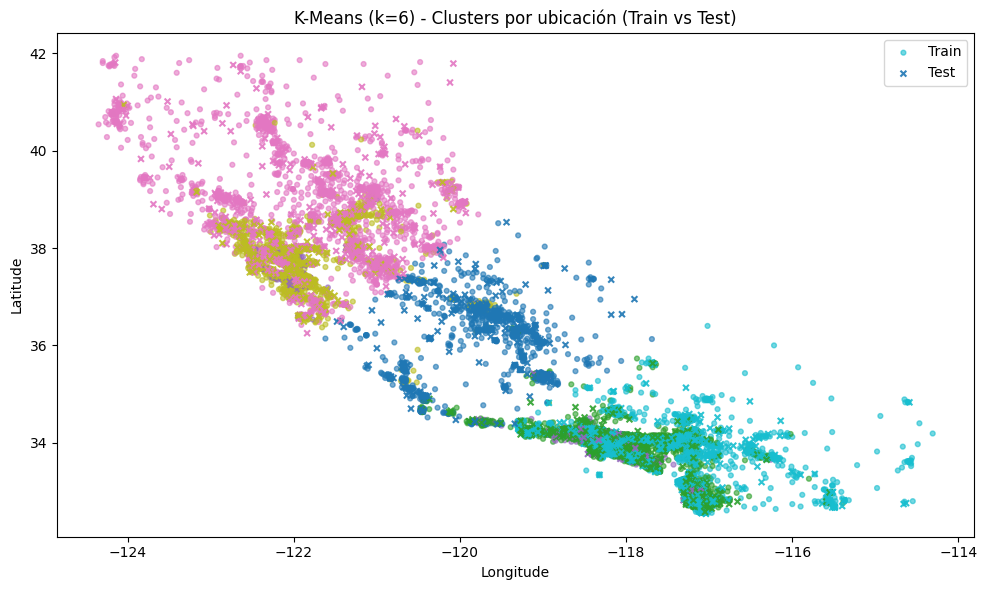

In [7]:
# Se crea una figura.
plt.figure(figsize=(10, 6))

# Se grafica TRAIN.
plt.scatter(
    train_df["Longitude"], train_df["Latitude"],
    c=train_df["cluster"],
    cmap="tab10",
    s=12,
    alpha=0.6,
    label="Train"
)

# Se grafica TEST encima.
plt.scatter(
    test_df["Longitude"], test_df["Latitude"],
    c=test_df["cluster"],
    cmap="tab10",
    s=18,
    marker="x",
    alpha=0.9,
    label="Test"
)

# Se configuran títulos y ejes.
plt.title("K-Means (k=6) - Clusters por ubicación (Train vs Test)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()


### Qué se observa?
- Zonas geográficas con colores similares indican **agrupamientos espaciales**.
- Como se incluye `MedInc`, clusters pueden separar regiones que comparten ubicación pero difieren en ingreso medio.
- Los puntos de test deberían caer en regiones coherentes con los clusters de train (misma estructura).

## 8. Modelo supervisado para predecir clusters
Ahora el **cluster** se usa como etiqueta (`y`) para entrenar un clasificador.
Se elige **RandomForestClassifier** porque:
- funciona bien sin supuestos fuertes,
- captura no linealidades,
- no requiere normalidad.

El objetivo aquí NO es predecir una variable real, sino aprender a reproducir la partición generada por K-Means.

In [8]:
# Se definen X e y para clasificación usando los datos escalados.
X_train_sup = X_train_scaled
y_train_sup = train_clusters

X_test_sup = X_test_scaled
y_test_sup = test_clusters

# Se inicializa el modelo supervisado.
clf = RandomForestClassifier(
    n_estimators=300,   # número de árboles
    random_state=42,    # replicabilidad
    n_jobs=-1           # usar todos los cores disponibles
)

# Se entrena el clasificador.
clf.fit(X_train_sup, y_train_sup)

# Se predice en test.
y_pred_sup = clf.predict(X_test_sup)

# Se evalúa.
acc = accuracy_score(y_test_sup, y_pred_sup)
print(f"Accuracy (clasificador vs clusters K-Means): {acc:.4f}")

print("\nMatriz de confusión:")
print(confusion_matrix(y_test_sup, y_pred_sup))

print("\nReporte de clasificación:")
print(classification_report(y_test_sup, y_pred_sup))


Accuracy (clasificador vs clusters K-Means): 0.9956

Matriz de confusión:
[[ 332    1    0    3    1    0]
 [   0  827    0    0    0    2]
 [   0    2  110    0    0    0]
 [   1    0    0  956    5    0]
 [   0    0    0    2  512    0]
 [   0    1    0    0    0 1373]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       337
           1       1.00      1.00      1.00       829
           2       1.00      0.98      0.99       112
           3       0.99      0.99      0.99       962
           4       0.99      1.00      0.99       514
           5       1.00      1.00      1.00      1374

    accuracy                           1.00      4128
   macro avg       1.00      0.99      0.99      4128
weighted avg       1.00      1.00      1.00      4128



## 9. Guardado de modelos
Se guardan:
- `scaler` (para transformar nuevos datos igual que train)
- `kmeans` (para asignar clusters)
- `clf` (para predecir cluster de forma supervisada)

Se guardan en una carpeta `models/`.

In [9]:
from pathlib import Path

# Se crea la carpeta de salida.
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Se guardan objetos.
joblib.dump(scaler, models_dir / "scaler_standard.pkl")
joblib.dump(kmeans, models_dir / "kmeans_k6.pkl")
joblib.dump(clf, models_dir / "rf_classifier_clusters.pkl")

print("Modelos guardados en:", models_dir.resolve())


Modelos guardados en: /workspaces/KMeans-CaliforniaHousing/src/models
